In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
train_df = pd.read_csv("train_auto.csv")
test_df = pd.read_csv("test_auto.csv")

# Data exploration

In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   INDEX        8161 non-null   int64  
 1   TARGET_FLAG  8161 non-null   int64  
 2   TARGET_AMT   8161 non-null   float64
 3   KIDSDRIV     8161 non-null   int64  
 4   AGE          8155 non-null   float64
 5   HOMEKIDS     8161 non-null   int64  
 6   YOJ          7707 non-null   float64
 7   INCOME       7716 non-null   object 
 8   PARENT1      8161 non-null   object 
 9   HOME_VAL     7697 non-null   object 
 10  MSTATUS      8161 non-null   object 
 11  SEX          8161 non-null   object 
 12  EDUCATION    8161 non-null   object 
 13  JOB          7635 non-null   object 
 14  TRAVTIME     8161 non-null   int64  
 15  CAR_USE      8161 non-null   object 
 16  BLUEBOOK     8161 non-null   object 
 17  TIF          8161 non-null   int64  
 18  CAR_TYPE     8161 non-null   object 
 19  RED_CA

Let's remove the features that are unsignificant to the problem : INDEX, TARGET_AMT

In [5]:
train_df.drop(['INDEX','TARGET_AMT'], axis = 1, inplace = True)
test_df.drop(['INDEX','TARGET_AMT'], axis = 1, inplace = True)
pass

In [6]:
train_df.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [7]:
train_df.tail()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
8156,0,0,35.0,0,11.0,"$43,112",No,$0,z_No,M,z_High School,z_Blue Collar,51,Commercial,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
8157,0,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,M,PhD,Manager,21,Private,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
8158,0,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,M,Masters,NaN,36,Commercial,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban
8159,0,0,50.0,0,7.0,"$43,445",No,"$149,248",Yes,z_F,Bachelors,Home Maker,36,Private,"$22,550",6,Minivan,no,$0,0,No,0,11.0,Highly Urban/ Urban
8160,0,0,52.0,0,11.0,"$53,235",No,"$197,017",Yes,z_F,z_High School,Clerical,64,Private,"$19,400",6,Minivan,no,$0,0,No,0,9.0,z_Highly Rural/ Rural


We have a mix of numerical and categorical features.

None of the features is predominantly null, therefore we don't discard any from the start

We notice that the features ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM'] are object type because of the dollar sign. 
We can treat these features to make them numerical.

We notice some typos in the EDUCATION field

In [8]:
def dollar_to_number(dollar_col):
    for i,dollar in enumerate(dollar_col):
        if pd.isna(dollar):
            continue
        dollar_col.iloc[i] = int(dollar[1:].replace(',',''))
    return dollar_col
train_df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']] = train_df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']].apply(dollar_to_number).astype('float64')
test_df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']] = test_df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']].apply(dollar_to_number).astype('float64')

In [9]:
train_df.EDUCATION.unique()

array(['PhD', 'z_High School', '<High School', 'Bachelors', 'Masters'],
      dtype=object)

There are typos in the education field, we fix them

In [10]:
train_df.EDUCATION = train_df.EDUCATION.replace(to_replace = {'z_High School' : 'High School', '<High School': 'High School'})
test_df.EDUCATION = train_df.EDUCATION.replace(to_replace = {'z_High School' : 'High School', '<High School': 'High School'})

### Repartition and correlation with the target of the numerical variables

In [11]:
train_df.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,61898.094609,154867.289723,33.485725,15709.899522,5.351305,4037.076216,0.798554,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,47572.682808,129123.774574,15.908333,8419.734075,4.146635,8777.139104,1.158453,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,28097.000000,0.000000,22.000000,9280.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,54028.000000,161160.000000,33.000000,14440.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,85986.000000,238724.000000,44.000000,20850.000000,7.000000,4636.000000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


The OLDCLAIM,CLM_FREQ and KIDSDRIV and HOMEKIDS fields are predominantly 0, let's check if we can remove them.
All the features related to money ie 'INCOME','BLUEBOOK' and 'HOME_VAL' are very spread. This kind of information ususally follows a power-law. It's worth checking if applying the log could be worth it.

We expect HOME_VAL and INCOME to be very correlated

#### HOMEKIDS

<AxesSubplot:xlabel='HOMEKIDS', ylabel='TARGET_FLAG'>

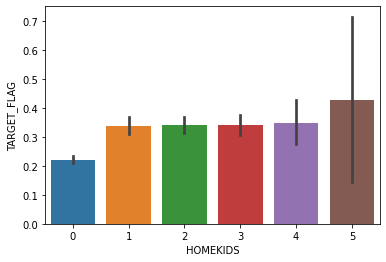

In [12]:
sns.barplot(data = train_df, x='HOMEKIDS', y='TARGET_FLAG')

We notice that the target is significantly lower when the person has no kids. There is no clear correlation past that. We replace this variable by the binary variable has_kids

#### KIDSDRIV

<AxesSubplot:xlabel='KIDSDRIV', ylabel='TARGET_FLAG'>

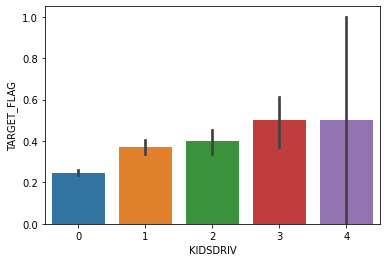

In [13]:
sns.barplot(data = train_df, x='KIDSDRIV', y='TARGET_FLAG')

Same observation. The error bars mean that we can't identify a clear correlation past 1 driving kid. We replace it by has_driving_kid.

#### CLM_FREQ

<AxesSubplot:xlabel='CLM_FREQ', ylabel='TARGET_FLAG'>

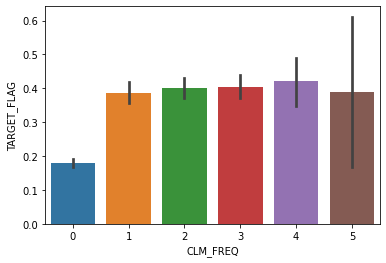

In [14]:
sns.barplot(data = train_df, x='CLM_FREQ', y='TARGET_FLAG')

Same observation again. We replace it by the binary "has_claim"

#### OLDCLAIM

<AxesSubplot:xlabel='OLDCLAIM', ylabel='Count'>

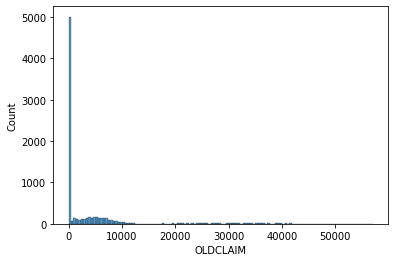

In [15]:
sns.histplot(data = train_df, x = 'OLDCLAIM')

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='OLDCLAIM'>

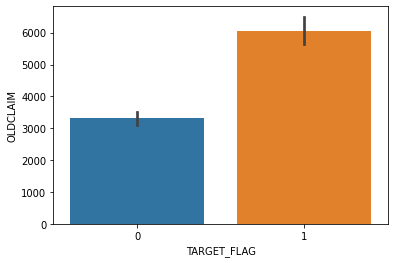

In [16]:
sns.barplot(data = train_df, x='TARGET_FLAG', y='OLDCLAIM')

Like we noticed previously, the values are predominantly zero. Still we notice a correlation between this variable and the target.

In [17]:
print(f'Share of insurance claims amongst oldclaim=0 : {train_df.loc[train_df.OLDCLAIM == 0].TARGET_FLAG.sum()/train_df.loc[train_df.OLDCLAIM == 0].TARGET_FLAG.count()}')
print(f'Share of insurance claims amongst oldclaim>0 : {train_df.loc[train_df.OLDCLAIM > 0].TARGET_FLAG.sum()/train_df.loc[train_df.OLDCLAIM == 0].TARGET_FLAG.count()}')

Share of insurance claims amongst oldclaim=0 : 0.17927730085845478
Share of insurance claims amongst oldclaim>0 : 0.2505490117787982


Once again, we will transform this variable in a binary : "has positive old claim"

#### INCOME

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='INCOME'>

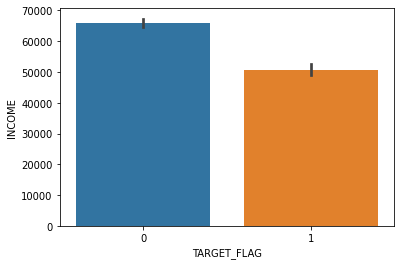

In [18]:
sns.barplot(data = train_df, x='TARGET_FLAG', y='INCOME')

We notice a negative correlation between the income and the probability of claim

<AxesSubplot:xlabel='INCOME', ylabel='Count'>

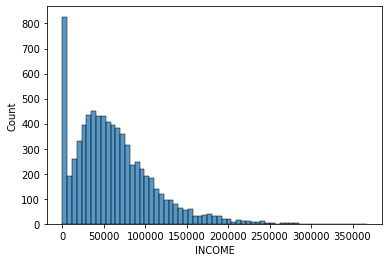

In [19]:
sns.histplot(data = train_df, x=train_df.INCOME)

<AxesSubplot:xlabel='INCOME', ylabel='TARGET_FLAG'>

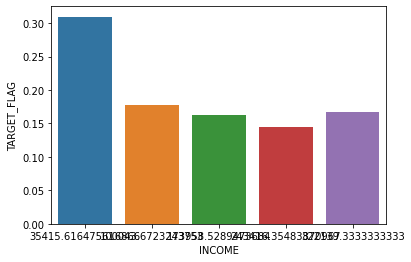

In [20]:
sns.barplot(data = train_df.groupby(pd.cut(train_df.INCOME,5)).mean(), x='INCOME',y='TARGET_FLAG')

Once again, we will transform this feature into the binary feature 'has_positive_income'

#### HOME_VAL

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='HOME_VAL'>

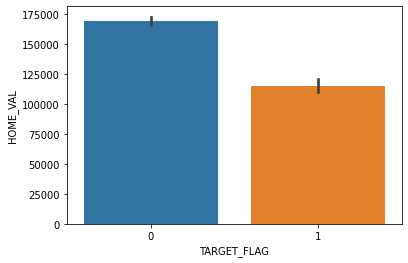

In [21]:
sns.barplot(data = train_df, x='TARGET_FLAG', y='HOME_VAL')

We notice a negative correlation between the home value and the probability of claim

<AxesSubplot:xlabel='HOME_VAL', ylabel='Count'>

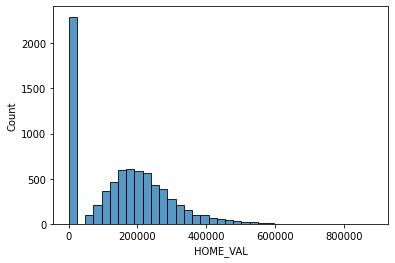

In [22]:
sns.histplot(data = train_df, x=train_df.HOME_VAL)

Looks like income but with more 0 values. We will transform this into the binary varaible "has_home"

#### BLUEBOOK

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='BLUEBOOK'>

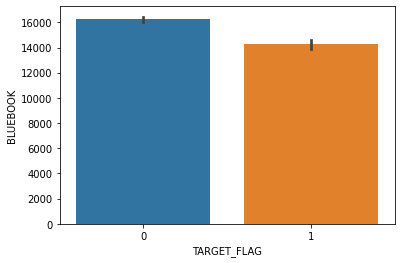

In [23]:
sns.barplot(data = train_df, x='TARGET_FLAG', y='BLUEBOOK')

We notice a slight negative correlation between the BLUEBOOK value and the probability of claim

<AxesSubplot:xlabel='BLUEBOOK', ylabel='Count'>

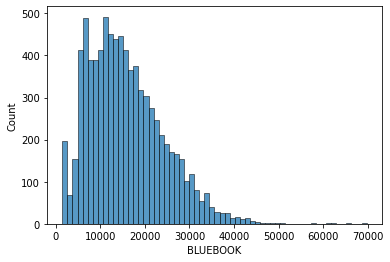

In [24]:
sns.histplot(data = train_df, x=train_df.BLUEBOOK)

<AxesSubplot:xlabel='BLUEBOOK', ylabel='Count'>

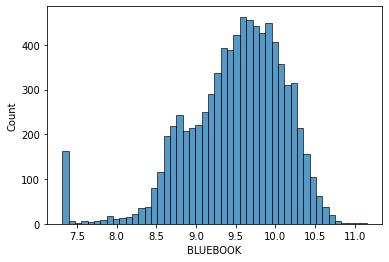

In [25]:
sns.histplot(data = train_df, x=np.log(train_df.BLUEBOOK+1))

<AxesSubplot:xlabel='BLUEBOOK', ylabel='TARGET_FLAG'>

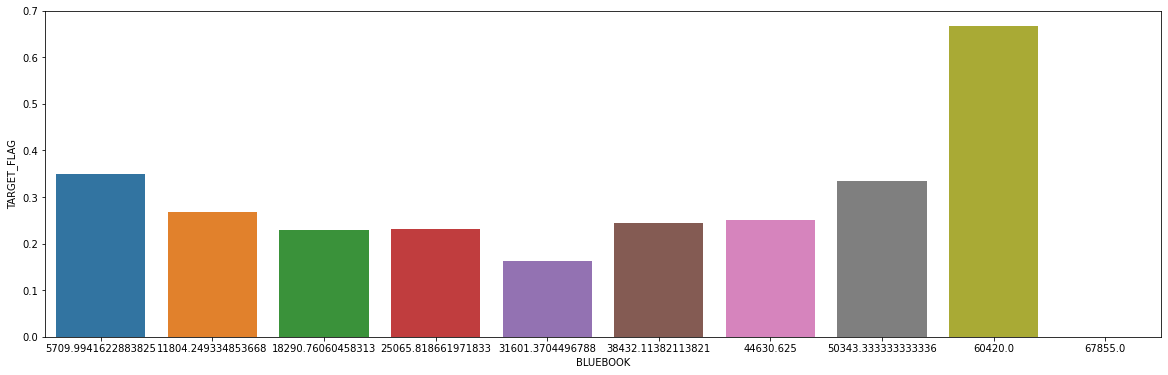

In [26]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df.groupby(pd.cut(train_df.BLUEBOOK,10)).mean(), x='BLUEBOOK',y='TARGET_FLAG',ax=ax)

It's difficult to see a clear correlation. We could remove this variable. If we keep it, using the log transform unskews it.

#### AGE

<AxesSubplot:xlabel='AGE', ylabel='Count'>

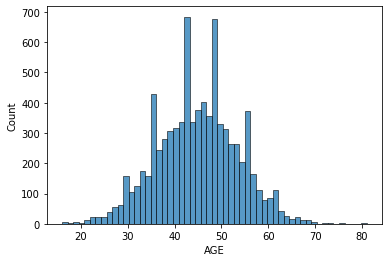

In [27]:
sns.histplot(data=train_df, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='TARGET_FLAG'>

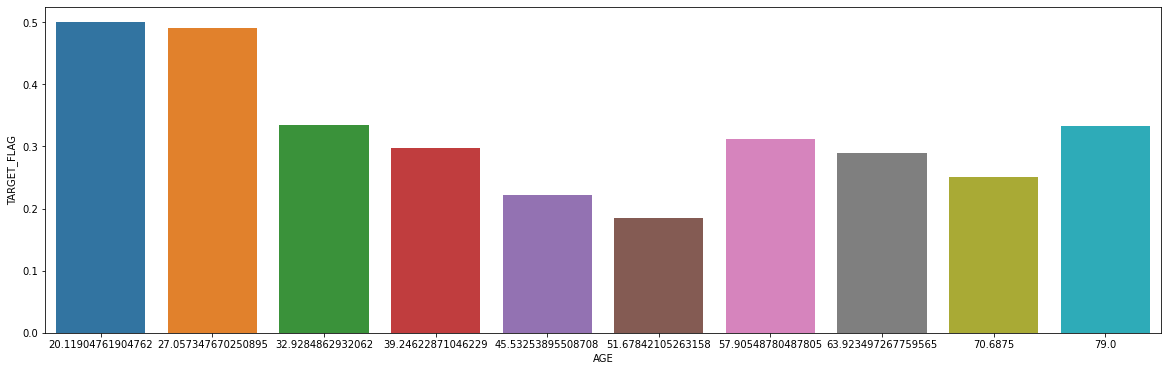

In [28]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df.groupby(pd.cut(train_df.AGE,10)).mean(), x='AGE',y='TARGET_FLAG',ax=ax)

<AxesSubplot:xlabel='AGE', ylabel='TARGET_FLAG'>

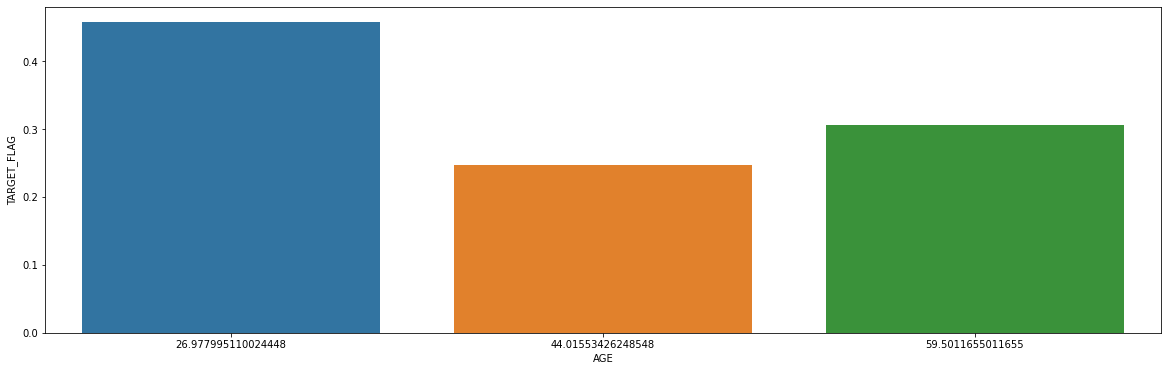

In [29]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df.groupby(pd.cut(train_df.AGE,[0,30,55,100])).mean(), x='AGE',y='TARGET_FLAG',ax=ax)

We expect that the claim rate is higher for younger and older people. This is also what we can see on the plot above. 

We can create an ordinal variable : 0 if age < 30, 1 if  30<age<55 2 if age >55

#### YOJ

<AxesSubplot:xlabel='YOJ', ylabel='Count'>

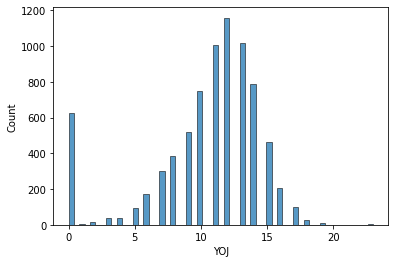

In [30]:
sns.histplot(data=train_df, x='YOJ')

<AxesSubplot:xlabel='YOJ', ylabel='TARGET_FLAG'>

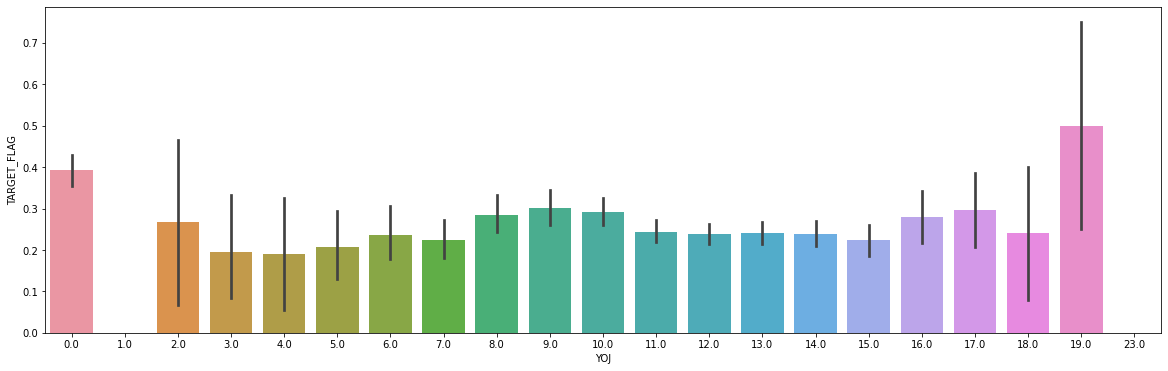

In [31]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df, x='YOJ',y='TARGET_FLAG',ax=ax)

Persons with 0 YOJ have a higher chance of claim. We make this field a binary variable: YOJ_0

#### TRAVTIME

<AxesSubplot:xlabel='TRAVTIME', ylabel='Count'>

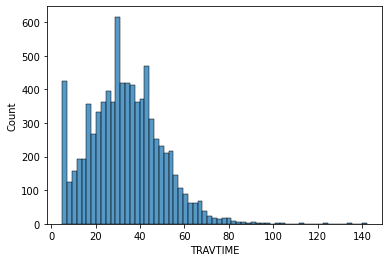

In [32]:
sns.histplot(data=train_df, x='TRAVTIME')

Data is skewed to the right, we take the log

<AxesSubplot:xlabel='TRAVTIME', ylabel='Count'>

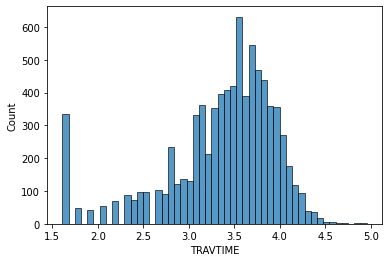

In [33]:
sns.histplot(data=train_df, x=np.log(train_df['TRAVTIME']))

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='TRAVTIME'>

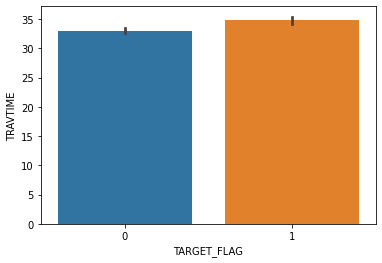

In [34]:
sns.barplot(data = train_df, x='TARGET_FLAG',y='TRAVTIME')

<AxesSubplot:xlabel='TRAVTIME', ylabel='TARGET_FLAG'>

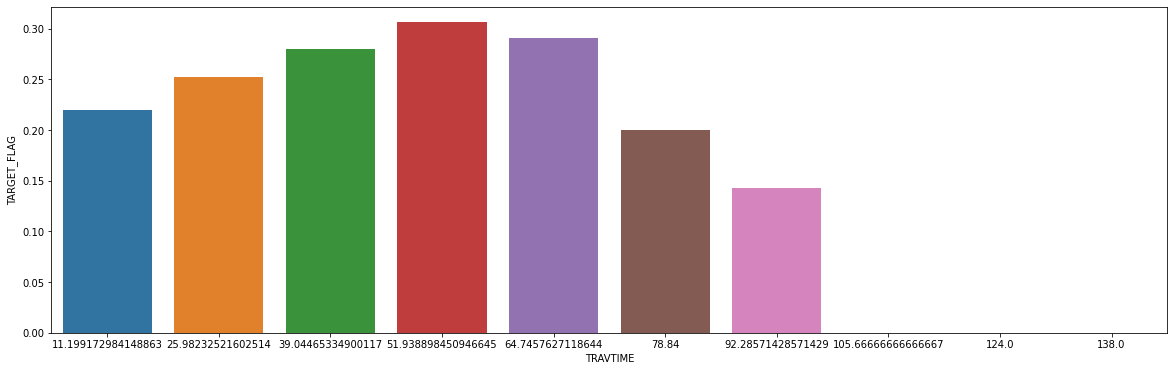

In [35]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df.groupby(pd.cut(train_df.TRAVTIME,10)).mean(), x='TRAVTIME',y='TARGET_FLAG')

We notice a positive correlation between travel time and risk of insurance claim, which is to be expected.
We take the log of this variable to unskew it

#### TIF

<AxesSubplot:xlabel='TIF', ylabel='Count'>

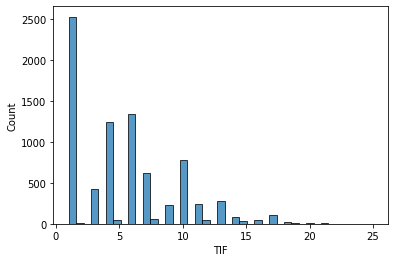

In [36]:
sns.histplot(data=train_df, x=train_df['TIF'])

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='TIF'>

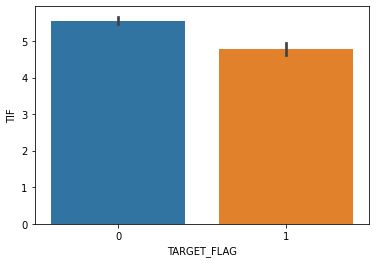

In [37]:
sns.barplot(data = train_df, x='TARGET_FLAG',y='TIF')

<AxesSubplot:xlabel='TIF', ylabel='TARGET_FLAG'>

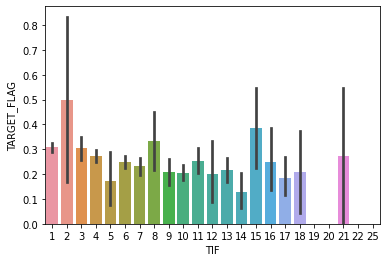

In [38]:
sns.barplot(data = train_df, x='TIF',y='TARGET_FLAG')

In [39]:
train_df.loc[train_df.TIF == 1].TARGET_FLAG.mean()

0.30793525463876825

In [40]:
train_df.loc[train_df.TIF != 1].TARGET_FLAG.mean()

0.2439587775408671

We notice that the risk of claim decreases as TIF increases, but there is a large amount of 1 value. We transfrom this variable as a binary : is_TIF_1

#### MVR_PTS

This Motor vehicle record points, a score of the quality of the driving (lower the better). We expect it to be positively correlated with claim risk 

<AxesSubplot:xlabel='MVR_PTS', ylabel='Count'>

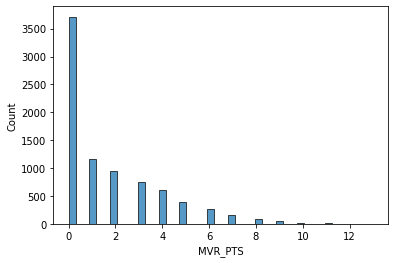

In [41]:
sns.histplot(data=train_df, x='MVR_PTS')

<AxesSubplot:xlabel='MVR_PTS', ylabel='TARGET_FLAG'>

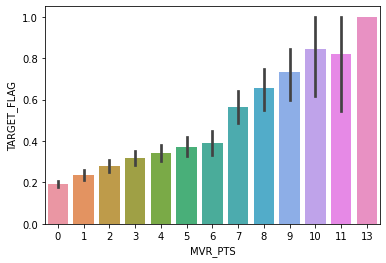

In [42]:
sns.barplot(data = train_df, x='MVR_PTS',y='TARGET_FLAG')

We have a nice positive correlation. We can put all the values above 10 at 10 because there are so few

#### CAR_AGE

We expect the risk of claim to increase with the age of the car

<AxesSubplot:xlabel='CAR_AGE', ylabel='Count'>

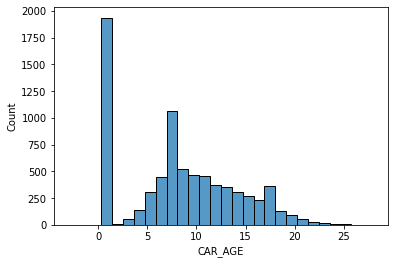

In [43]:
sns.histplot(data=train_df, x='CAR_AGE')

In [44]:
train_df.loc[train_df.CAR_AGE<0]

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
6940,1,0,47.0,0,12.0,48696.0,No,212014.0,z_No,z_F,Bachelors,Professional,46,Private,15390.0,4,Pickup,no,33521.0,3,Yes,1,-3.0,Highly Urban/ Urban


We have a car with negative age. This is probably a mistake. We fix negative values with 0, the most frequent age

In [45]:
train_df.loc[train_df.CAR_AGE<0,'CAR_AGE'] = 0

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='CAR_AGE'>

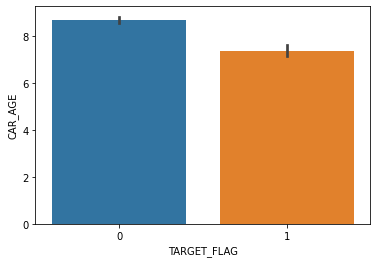

In [46]:
sns.barplot(data = train_df, x='TARGET_FLAG',y='CAR_AGE')

<AxesSubplot:xlabel='CAR_AGE', ylabel='TARGET_FLAG'>

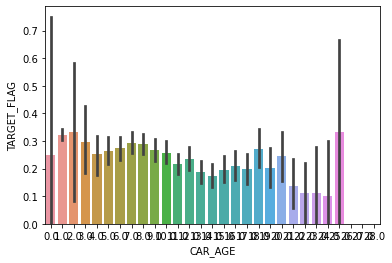

In [47]:
sns.barplot(data = train_df, x='CAR_AGE',y='TARGET_FLAG')

Unexpectedly, we have a negative correlation between CAR_AGE and the target. The distribution is almost normal past the 0 value. We leave this feature as is

### Repartition and correlation with the target of the object variables

In [48]:
train_df.describe(include=['O'])

,PARENT1,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
count,8161,8161,8161,8161,7635,8161,8161,8161,8161,8161
unique,2,2,2,4,8,2,6,2,2,2
top,No,Yes,z_F,High School,z_Blue Collar,Private,z_SUV,no,No,Highly Urban/ Urban
freq,7084,4894,4375,3533,1825,5132,2294,5783,7161,6492


#### PARENT1

This tell us if the driver is a single parent. We may expect them to be slightly more precautious

<AxesSubplot:xlabel='PARENT1', ylabel='Count'>

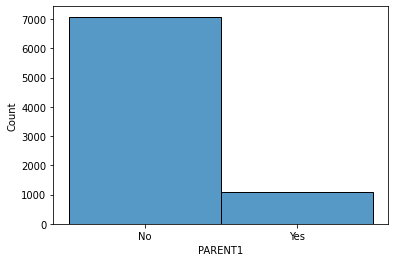

In [49]:
sns.histplot(data=train_df, x='PARENT1')

<AxesSubplot:xlabel='PARENT1', ylabel='TARGET_FLAG'>

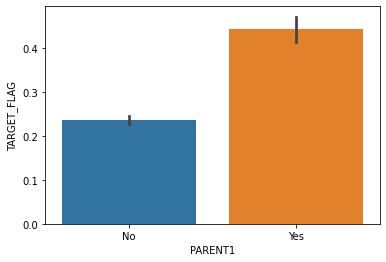

In [50]:
sns.barplot(data=train_df, x='PARENT1',y='TARGET_FLAG')

Unexpectedly, single parents have a higher risk. We make it binary : is_single_parent

#### MSTATUS

This tell us if the driver is a married. We may expect them to be slightly more precautious

<AxesSubplot:xlabel='MSTATUS', ylabel='Count'>

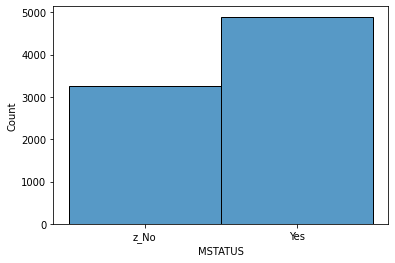

In [51]:
sns.histplot(data=train_df, x='MSTATUS')

<AxesSubplot:xlabel='MSTATUS', ylabel='TARGET_FLAG'>

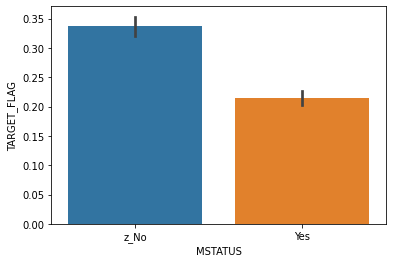

In [52]:
sns.barplot(data=train_df, x='MSTATUS',y='TARGET_FLAG')

Same correlation as expected. We make it binary : "is_married"

#### SEX

We expect women to be safer drivers

<AxesSubplot:xlabel='SEX', ylabel='Count'>

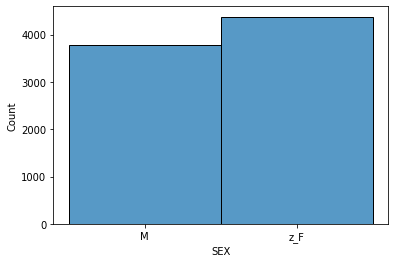

In [53]:
sns.histplot(data=train_df, x='SEX')

<AxesSubplot:xlabel='SEX', ylabel='TARGET_FLAG'>

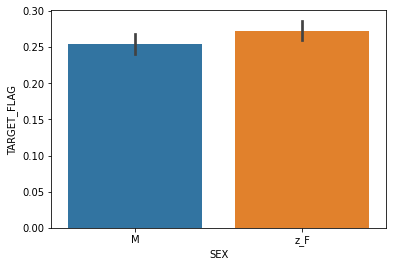

In [54]:
sns.barplot(data=train_df, x='SEX',y='TARGET_FLAG')

We notice a slight correlation, we make it binary : is_male

#### EDUCATION

<AxesSubplot:xlabel='EDUCATION', ylabel='Count'>

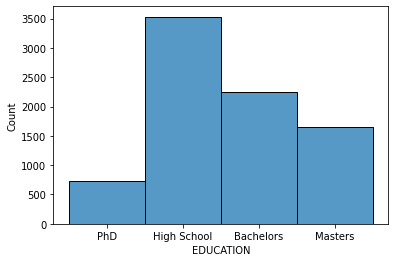

In [55]:
sns.histplot(data=train_df, x='EDUCATION')

<AxesSubplot:xlabel='EDUCATION', ylabel='TARGET_FLAG'>

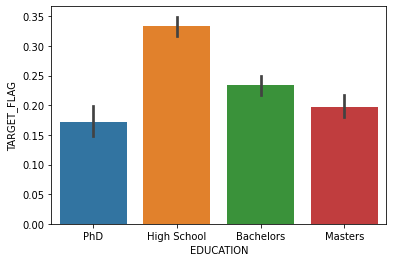

In [56]:
sns.barplot(data=train_df, x='EDUCATION',y='TARGET_FLAG')

We notice a strong risk increase for the least educated. The other values are similar. We transform this variable as a binary : has_higher_education

#### JOB

We expect blue collar jobs and students to have a higher risk

<AxesSubplot:xlabel='JOB', ylabel='Count'>

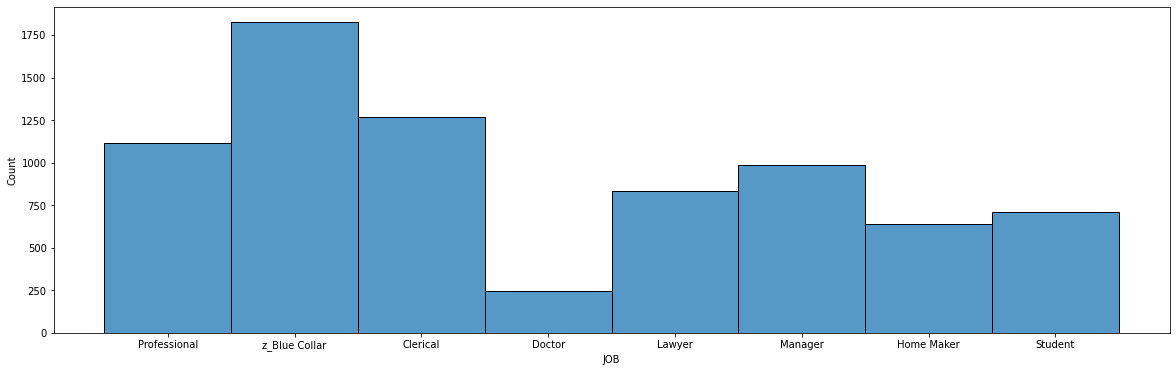

In [57]:
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(data = train_df, x='JOB',ax=ax)

<AxesSubplot:xlabel='JOB', ylabel='TARGET_FLAG'>

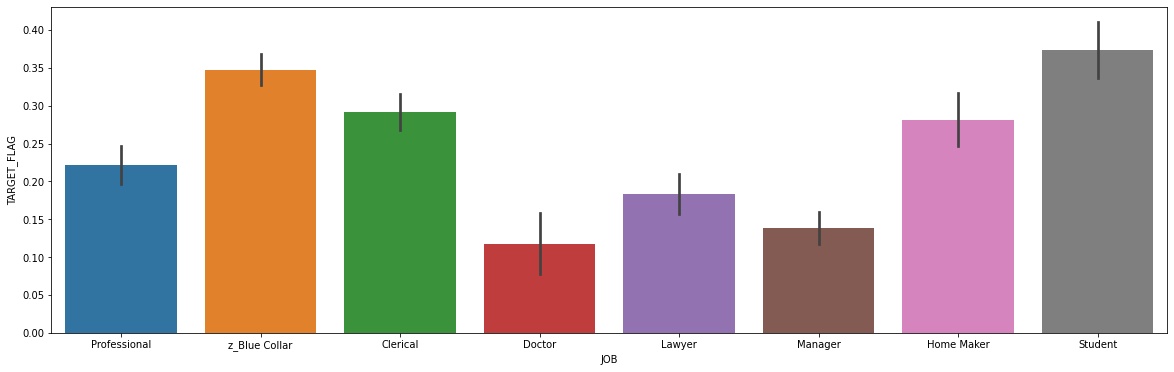

In [58]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data = train_df, x='JOB',y='TARGET_FLAG',ax=ax)

As expected,blue collar and students have a higher risk. Doctor,lawyers and managers have substantially lower risk. We create a var with 3 values : low_rank for students and blue_collars, highest_rank for Doctor,lawyers and managers; and other for the rest

#### CAR_TYPE

<AxesSubplot:xlabel='CAR_TYPE', ylabel='Count'>

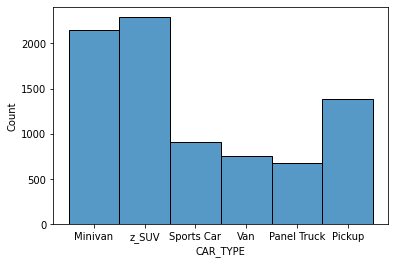

In [59]:
sns.histplot(data = train_df, x='CAR_TYPE')

<AxesSubplot:xlabel='CAR_TYPE', ylabel='TARGET_FLAG'>

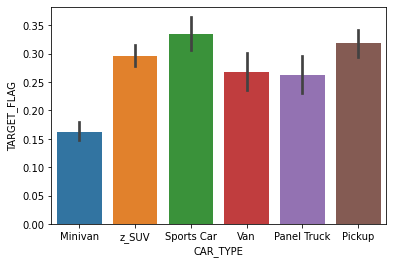

In [60]:
sns.barplot(data = train_df, x='CAR_TYPE',y='TARGET_FLAG')

We notice that minivans have a much lower risk. We create a variable "is_minivan"

#### RED_CAR

<AxesSubplot:xlabel='RED_CAR', ylabel='Count'>

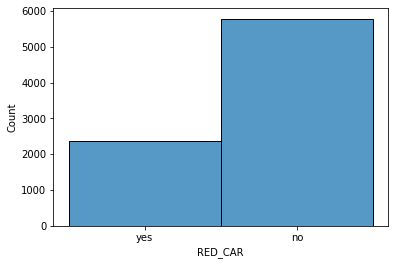

In [61]:
sns.histplot(data = train_df, x='RED_CAR')

<AxesSubplot:xlabel='RED_CAR', ylabel='TARGET_FLAG'>

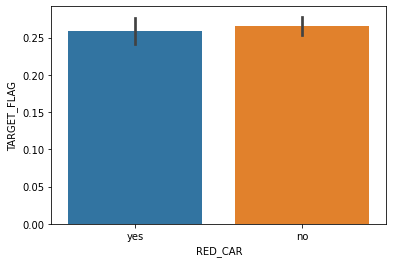

In [62]:
sns.barplot(data = train_df, x='RED_CAR',y='TARGET_FLAG')

The color of the car as no impact on risk, as expected. We remove this feature

#### REVOKED

People who lost their license most likely have a higher risk

<AxesSubplot:xlabel='REVOKED', ylabel='Count'>

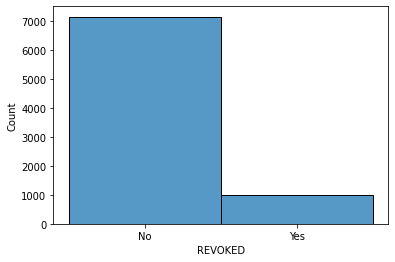

In [63]:
sns.histplot(data = train_df, x='REVOKED')

<AxesSubplot:xlabel='REVOKED', ylabel='TARGET_FLAG'>

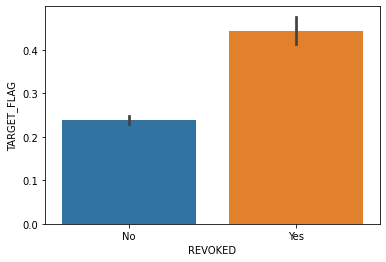

In [64]:
sns.barplot(data = train_df, x='REVOKED',y='TARGET_FLAG')

We notice a strong correlation. We make it binary : 'has_lost_license"

#### URBANICITY

<AxesSubplot:xlabel='URBANICITY', ylabel='Count'>

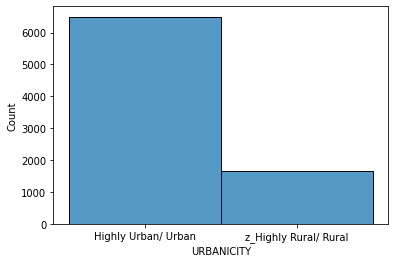

In [65]:
sns.histplot(data = train_df, x='URBANICITY')

<AxesSubplot:xlabel='URBANICITY', ylabel='TARGET_FLAG'>

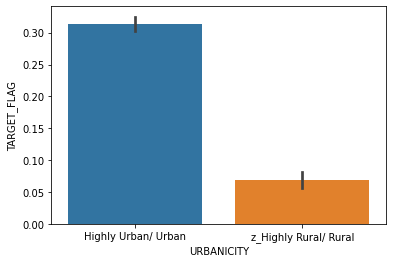

In [66]:
sns.barplot(data = train_df, x='URBANICITY',y='TARGET_FLAG')

We find a much lower risk in rural areas. We make it binary : "is_urban"

#### CAR_USE

<AxesSubplot:xlabel='CAR_USE', ylabel='Count'>

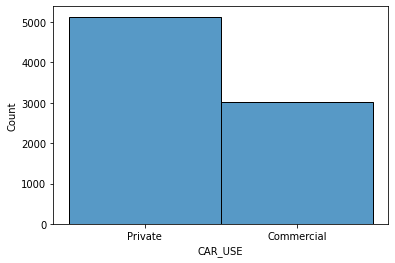

In [67]:
sns.histplot(data = train_df, x='CAR_USE')

<AxesSubplot:xlabel='CAR_USE', ylabel='TARGET_FLAG'>

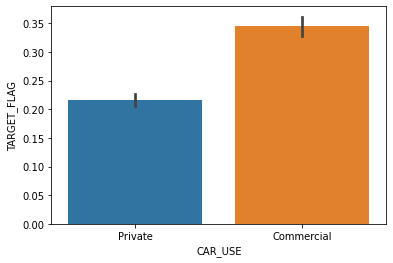

In [68]:
sns.barplot(data = train_df, x='CAR_USE',y='TARGET_FLAG')

Commercial has higher risk. We transform this in a binary 'is_commercial'

# Apply the transforms chosen

In [69]:
train_df.HOMEKIDS = (train_df.HOMEKIDS>0).astype(int)
test_df.HOMEKIDS = (test_df.HOMEKIDS>0).astype(int)
train_df.rename(columns={"HOMEKIDS": "has_kids"},inplace = True)
test_df.rename(columns={"HOMEKIDS": "has_kids"},inplace = True)

In [70]:
train_df.KIDSDRIV = (train_df.KIDSDRIV>0).astype(int)
test_df.KIDSDRIV = (test_df.KIDSDRIV>0).astype(int)
train_df.rename(columns={"KIDSDRIV": "has_driving_kid"},inplace = True)
test_df.rename(columns={"KIDSDRIV": "has_driving_kid"},inplace = True)

In [71]:
train_df.CLM_FREQ = (train_df.CLM_FREQ>0).astype(int)
test_df.CLM_FREQ = (test_df.CLM_FREQ>0).astype(int)
train_df.rename(columns={"CLM_FREQ": "has_claim"},inplace = True)
test_df.rename(columns={"CLM_FREQ": "has_claim"},inplace = True)

In [72]:
train_df.OLDCLAIM = (train_df.OLDCLAIM>0).astype(int)
test_df.OLDCLAIM = (test_df.OLDCLAIM>0).astype(int)
train_df.rename(columns={"OLDCLAIM": "has_positive_old_claim"},inplace = True)
test_df.rename(columns={"OLDCLAIM": "has_positive_old_claim"},inplace = True)

In [73]:
train_df.INCOME = (train_df.INCOME>0).astype(int)
test_df.INCOME = (test_df.INCOME>0).astype(int)
train_df.rename(columns={"INCOME": "has_positive_income"},inplace = True)
test_df.rename(columns={"INCOME": "has_positive_income"},inplace = True)

In [74]:
train_df.HOME_VAL = (train_df.HOME_VAL>0).astype(int)
test_df.HOME_VAL = (test_df.HOME_VAL>0).astype(int)
train_df.rename(columns={"HOME_VAL": "has_home"},inplace = True)
test_df.rename(columns={"HOME_VAL": "has_home"},inplace = True)

In [75]:
train_df.BLUEBOOK = np.log(train_df.BLUEBOOK+1)
test_df.BLUEBOOK = np.log(test_df.BLUEBOOK+1)

In [76]:
def build_age(age): #we replace the missing age by the mean
    if pd.isna(age) or (age >=30 and age<=55) :
        age = 1
    else:
        age = 0 if age<30 else 2
    return age
train_df.AGE = train_df.AGE.apply(build_age)
test_df.AGE = test_df.AGE.apply(build_age)

In [77]:
train_df.YOJ = (train_df.YOJ == 0).astype(int)
test_df.YOJ = (test_df.YOJ == 0).astype(int)
train_df.rename(columns={"YOJ": "is_YOJ_0"},inplace = True)
test_df.rename(columns={"YOJ": "is_YOJ_0"},inplace = True)

In [78]:
train_df.TRAVTIME = np.log(train_df.TRAVTIME)
test_df.TRAVTIME = np.log(test_df.TRAVTIME)

In [79]:
train_df.TIF = (train_df.TIF == 1).astype(int)
test_df.TIF = (test_df.TIF == 1).astype(int)
train_df.rename(columns={"TIF": "is_TIF_1"},inplace = True)
test_df.rename(columns={"TIF": "is_TIF_1"},inplace = True)

In [80]:
def cap_at_10(mvr):
    return mvr if mvr<=10 else 10
train_df.MVR_PTS = train_df.MVR_PTS.apply(cap_at_10)
test_df.MVR_PTS = test_df.MVR_PTS.apply(cap_at_10)

In [81]:
train_df.PARENT1 = train_df.PARENT1.map({'No':0,'Yes':1})
test_df.PARENT1 = test_df.PARENT1.map({'No':0,'Yes':1})
train_df.rename(columns = {'PARENT1' : 'is_single_parent'}, inplace = True)
test_df.rename(columns = {'PARENT1' : 'is_single_parent'}, inplace = True)

In [82]:
train_df.MSTATUS = train_df.MSTATUS.map({'z_No':0,'Yes':1})
test_df.MSTATUS = test_df.MSTATUS.map({'z_No':0,'Yes':1})
train_df.rename(columns = {'MSTATUS' : 'is_married'}, inplace = True)
test_df.rename(columns = {'MSTATUS' : 'is_married'}, inplace = True)

In [83]:
train_df.SEX = train_df.SEX.map({'z_F':0,'M':1})
test_df.SEX = test_df.SEX.map({'z_F':0,'M':1})
train_df.rename(columns = {'SEX' : 'is_male'}, inplace = True)
test_df.rename(columns = {'SEX' : 'is_male'}, inplace = True)

In [84]:
train_df.EDUCATION = train_df.EDUCATION.map({'High School':0,'PhD':1,'Bachelors':1,'Masters':1})
test_df.EDUCATION = test_df.EDUCATION.map({'High School':0,'PhD':1,'Bachelors':1,'Masters':1})
train_df.rename(columns = {'EDUCATION' : 'has_higher_education'}, inplace = True)
test_df.rename(columns = {'EDUCATION' : 'has_higher_education'}, inplace = True)

In [85]:
mapping = {'Professional': 'other',
 'z_Blue Collar': 'low_rank',
 'Clerical': 'other',
 'Doctor': 'highest_rank',
 'Lawyer': 'highest_rank',
 'Manager': 'highest_rank',
 'Home Maker': 'other',
 'Student': 'low_rank'}
train_df.JOB = train_df.JOB.map(mapping)
test_df.JOB = test_df.JOB.map(mapping)

In [86]:
mapping = {'Minivan': 1,
 'z_SUV': 0,
 'Sports Car': 0,
 'Van': 0,
 'Panel Truck': 0,
 'Pickup': 0}
train_df.CAR_TYPE = train_df.CAR_TYPE.map(mapping)
test_df.CAR_TYPE = test_df.CAR_TYPE.map(mapping)
train_df.rename(columns = {'CAR_TYPE' : 'is_minivan'}, inplace = True)
test_df.rename(columns = {'CAR_TYPE' : 'is_minivan'}, inplace = True)

In [87]:
train_df = train_df.drop(["RED_CAR"],axis = 1)
test_df = test_df.drop(["RED_CAR"],axis = 1)

In [88]:
train_df.REVOKED = train_df.REVOKED.map({'No':0,'Yes':1})
test_df.REVOKED = test_df.REVOKED.map({'No':0,'Yes':1})
train_df.rename(columns = {'REVOKED' : 'has_lost_license'}, inplace = True)
test_df.rename(columns = {'REVOKED' : 'has_lost_license'}, inplace = True)

In [89]:
train_df.URBANICITY.unique()

array(['Highly Urban/ Urban', 'z_Highly Rural/ Rural'], dtype=object)

In [90]:
train_df.URBANICITY = train_df.URBANICITY.map({'z_Highly Rural/ Rural':0,'Highly Urban/ Urban':1})
test_df.URBANICITY = test_df.URBANICITY.map({'z_Highly Rural/ Rural':0,'Highly Urban/ Urban':1})
train_df.rename(columns = {'URBANICITY' : 'is_urban'}, inplace = True)
test_df.rename(columns = {'URBANICITY' : 'is_urban'}, inplace = True)

In [91]:
train_df.CAR_USE = train_df.CAR_USE.map({'Private':0,'Commercial':1})
test_df.CAR_USE = test_df.CAR_USE.map({'Private':0,'Commercial':1})
train_df.rename(columns = {'CAR_USE' : 'is_commercial'}, inplace = True)
test_df.rename(columns = {'CAR_USE' : 'is_commercial'}, inplace = True)

# Find correlation between variables

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TARGET_FLAG             8161 non-null   int64  
 1   has_driving_kid         8161 non-null   int32  
 2   AGE                     8161 non-null   int64  
 3   has_kids                8161 non-null   int32  
 4   is_YOJ_0                8161 non-null   int32  
 5   has_positive_income     8161 non-null   int32  
 6   is_single_parent        8161 non-null   int64  
 7   has_home                8161 non-null   int32  
 8   is_married              8161 non-null   int64  
 9   is_male                 8161 non-null   int64  
 10  has_higher_education    8161 non-null   int64  
 11  JOB                     7635 non-null   object 
 12  TRAVTIME                8161 non-null   float64
 13  is_commercial           8161 non-null   int64  
 14  BLUEBOOK                8161 non-null   

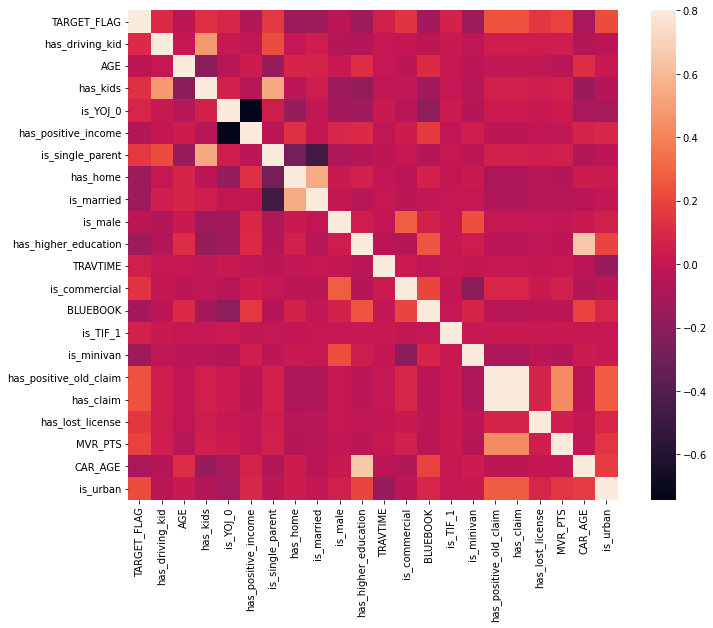

In [93]:
corrmat = train_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We notice that has_positive_old_claim is perfectly correlatied to has_claim. We remove has_positive_old_claim

We notice a strong correlation between has_higher_education and CAR_AGE. We can use this information to impute missing data

We find some expected correlations between has_home and is_married or has_kids and is_single_parent or has_kids and has_driving_kids

In [94]:
train_df = train_df.drop(['has_positive_old_claim'],axis = 1)
test_df = test_df.drop(['has_positive_old_claim'],axis = 1)

We expect the variable JOB to be correlated to has_higher_education

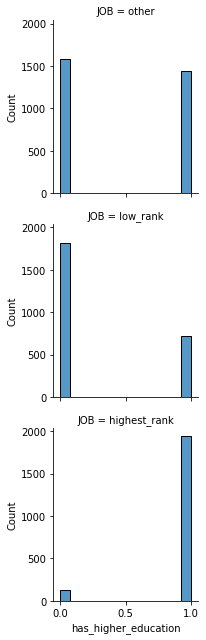

In [95]:
g = sns.FacetGrid(data = train_df, row = 'JOB')
g.map(sns.histplot,'has_higher_education')

We notice a correlation as expected

# Fill missing values

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TARGET_FLAG           8161 non-null   int64  
 1   has_driving_kid       8161 non-null   int32  
 2   AGE                   8161 non-null   int64  
 3   has_kids              8161 non-null   int32  
 4   is_YOJ_0              8161 non-null   int32  
 5   has_positive_income   8161 non-null   int32  
 6   is_single_parent      8161 non-null   int64  
 7   has_home              8161 non-null   int32  
 8   is_married            8161 non-null   int64  
 9   is_male               8161 non-null   int64  
 10  has_higher_education  8161 non-null   int64  
 11  JOB                   7635 non-null   object 
 12  TRAVTIME              8161 non-null   float64
 13  is_commercial         8161 non-null   int64  
 14  BLUEBOOK              8161 non-null   float64
 15  is_TIF_1             

In [97]:
most_frequent_job = train_df.JOB.mode()[0]
train_df.JOB = train_df.JOB.fillna(most_frequent_job)
test_df.JOB = test_df.JOB.fillna(most_frequent_job)

car_age_no_ed = train_df.loc[train_df.has_higher_education == 0, 'CAR_AGE'].median()
car_age_ed = train_df.loc[train_df.has_higher_education == 1, 'CAR_AGE'].median()

#We use the corr between has_higher_education and car_age
train_df.loc[(train_df.CAR_AGE.isna()) & (train_df.has_higher_education == 0), 'CAR_AGE'] = train_df.loc[(train_df.CAR_AGE.isna()) & (train_df.has_higher_education == 0), 'CAR_AGE'].fillna(car_age_no_ed)
test_df.loc[(test_df.CAR_AGE.isna()) & (test_df.has_higher_education == 0), 'CAR_AGE'] = test_df.loc[(test_df.CAR_AGE.isna()) & (train_df.has_higher_education == 0), 'CAR_AGE'].fillna(car_age_no_ed)

train_df.loc[(train_df.CAR_AGE.isna()) & (train_df.has_higher_education == 1), 'CAR_AGE'] = train_df.loc[(train_df.CAR_AGE.isna()) & (train_df.has_higher_education == 1), 'CAR_AGE'].fillna(car_age_ed)
test_df.loc[(test_df.CAR_AGE.isna()) & (test_df.has_higher_education == 1), 'CAR_AGE'] = test_df.loc[(test_df.CAR_AGE.isna()) & (train_df.has_higher_education == 1), 'CAR_AGE'].fillna(car_age_ed)

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TARGET_FLAG           8161 non-null   int64  
 1   has_driving_kid       8161 non-null   int32  
 2   AGE                   8161 non-null   int64  
 3   has_kids              8161 non-null   int32  
 4   is_YOJ_0              8161 non-null   int32  
 5   has_positive_income   8161 non-null   int32  
 6   is_single_parent      8161 non-null   int64  
 7   has_home              8161 non-null   int32  
 8   is_married            8161 non-null   int64  
 9   is_male               8161 non-null   int64  
 10  has_higher_education  8161 non-null   int64  
 11  JOB                   8161 non-null   object 
 12  TRAVTIME              8161 non-null   float64
 13  is_commercial         8161 non-null   int64  
 14  BLUEBOOK              8161 non-null   float64
 15  is_TIF_1             

# Preparing the data for training

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='Count'>

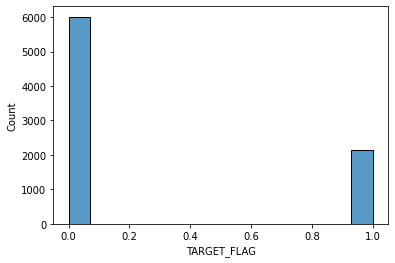

In [99]:
sns.histplot(data = train_df, x=train_df.TARGET_FLAG)

Our dataset is unbalanced. We will use the f1 score to compare our models beacause accuracy could be misleading : a model only outputing 0 will have a decent score

In [100]:
test_df.columns

Index(['TARGET_FLAG', 'has_driving_kid', 'AGE', 'has_kids', 'is_YOJ_0',
       'has_positive_income', 'is_single_parent', 'has_home', 'is_married',
       'is_male', 'has_higher_education', 'JOB', 'TRAVTIME', 'is_commercial',
       'BLUEBOOK', 'is_TIF_1', 'is_minivan', 'has_claim', 'has_lost_license',
       'MVR_PTS', 'CAR_AGE', 'is_urban'],
      dtype='object')

In [101]:
train_x = train_df.drop(columns = ['TARGET_FLAG'],axis=1)
train_y = train_df.TARGET_FLAG
test_x = test_df.drop(columns = ['TARGET_FLAG'],axis=1)

train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

normalizer = Normalizer().fit(train_x)
train_x=normalizer.transform(train_x)
test_x=normalizer.transform(test_x)

# Finding the best model

### Logistic regression

In [102]:
logreg = LogisticRegression(max_iter =1000)
scores = cross_val_score(logreg, train_x, train_y, cv=5,scoring='f1')
print(scores.mean())

0.34857789666533756


In [103]:
logreg.fit(train_x,train_y)
features_importance = pd.DataFrame(train_df.drop(columns = ['TARGET_FLAG'],axis=1).columns)
features_importance['Score'] = pd.Series(logreg.coef_[0])
print(features_importance)

                       0      Score
0        has_driving_kid   2.684026
1                    AGE   1.010715
2               has_kids   2.552010
3               is_YOJ_0   1.623482
4    has_positive_income  -1.176824
5       is_single_parent   2.567776
6               has_home  -2.590921
7             is_married  -4.256325
8                is_male  -0.344763
9   has_higher_education  -3.186827
10                   JOB   2.897659
11              TRAVTIME   4.615719
12         is_commercial  -2.479610
13              BLUEBOOK   2.768988
14              is_TIF_1  -4.543487
15            is_minivan   4.728442
16             has_claim   5.123225
17      has_lost_license   1.918994
18               MVR_PTS  -0.287969
19               CAR_AGE  11.603586
20              is_urban  -3.521219


It's interesting to look at which feature influences the score the most. We find the same correlations we identified in our data exploration : being urban or having lost our licence greatly increases risk while driving a minivan decreases it for instance.

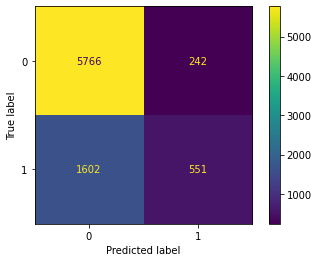

In [104]:
ConfusionMatrixDisplay.from_estimator(logreg, train_x, train_y)

We notice we have a lot of false negative. Our sensitivity is only 0.4 Considering that the train_dataset has more negative than positive, ths behaviour can be expected. We undersample our dataset to balance the classes

In [105]:
sample_size = sum(train_df.TARGET_FLAG == 1)
neg_indices = train_df.loc[train_df.TARGET_FLAG == 0].index
random_neg_indices = np.random.choice(neg_indices, sample_size, replace=False)

train_undersampled = pd.concat([train_df.loc[train_df.TARGET_FLAG == 1],train_df.loc[random_neg_indices]])
train_undersampled=train_undersampled.sample(frac=1) #shuffle the new dataset

In [106]:
train_undersampled.groupby('TARGET_FLAG').count().iloc[:,0]

TARGET_FLAG
0    2153
1    2153
Name: has_driving_kid, dtype: int64

In [107]:
train_undersampled_x = train_undersampled.drop(columns = ['TARGET_FLAG'],axis=1)
train_undersampled_y = train_undersampled.TARGET_FLAG

train_undersampled_x = pd.get_dummies(train_undersampled_x)

normalizer = Normalizer().fit(train_undersampled_x)
train_undersampled_x=normalizer.transform(train_undersampled_x)

In [108]:
logreg = LogisticRegression(max_iter =1000)
scores = cross_val_score(logreg, train_undersampled_x, train_undersampled_y, cv=5,scoring='f1')
print(scores.mean())
logreg.fit(train_undersampled_x, train_undersampled_y)

0.6923577188924085


LogisticRegression(max_iter=1000)

We increased our score

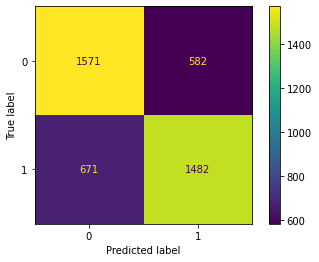

In [109]:
ConfusionMatrixDisplay.from_estimator(logreg, train_undersampled_x, train_undersampled_y)

We increased the sensitivity going from 0.4 to 0.68

### KNN

We find the best parameter for KNN with grid search and cross validation

In [110]:
parameters = {"n_neighbors":[i for i in range(1,10)]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters,scoring='f1')
clf.fit(train_x, train_y)
max(clf.cv_results_["mean_test_score"])

0.434762308824401

Undersampling

In [111]:
parameters = {"n_neighbors":[i for i in range(1,10)]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters,scoring='f1')
clf.fit(train_undersampled_x, train_undersampled_y)
max(clf.cv_results_["mean_test_score"])

0.6790520978476037

One again the better score is obtained with undersampling. Performance is slightly lower than logistic regression

### SVC

In [112]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3,5,10]}
svc = SVC()
clf = GridSearchCV(svc, parameters,scoring='f1')
clf.fit(train_x, train_y)
max(clf.cv_results_["mean_test_score"])

0.408999368601921

In [113]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3,5,10]}
svc = SVC()
clf = GridSearchCV(svc, parameters,scoring='f1')
clf.fit(train_undersampled_x, train_undersampled_y)
max(clf.cv_results_["mean_test_score"])

0.7387363897850014

In [114]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

We increased performance using SVC

### Random Forest

Random forest don't need normalization to function. We use a non normalized dataset

In [115]:
train_x = train_df.drop(columns = ['TARGET_FLAG'],axis=1)
train_x = pd.get_dummies(train_x)
train_undersampled_x = train_undersampled.drop(columns = ['TARGET_FLAG'],axis=1)
train_undersampled_y = train_undersampled.TARGET_FLAG

train_undersampled_x = pd.get_dummies(train_undersampled_x)

In [116]:
parameters = {'n_estimator':[10,100,200], 'max_depth': [10, 50, 100],'min_samples_split': [2, 5, 10]}

In [117]:
random_forest = RandomForestClassifier(n_estimators = 200)
scores = cross_val_score(random_forest, train_x, train_y, cv=5,scoring='f1')
print(scores.mean())

0.49026703926144766


In [118]:
random_forest = RandomForestClassifier(n_estimators = 200)
scores = cross_val_score(random_forest, train_undersampled_x, train_undersampled_y, cv=5,scoring='f1')
print(scores.mean())

0.7332912873971726


Again, our score is better with undersampling. We find the best hyperparameters

In [119]:
parameters = {'n_estimators':[10,100,200], 'max_depth': [50, 80, 100],'min_samples_split': [2, 5, 10]}
random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest,parameters, scoring='f1')
clf.fit(train_undersampled_x,train_undersampled_y)
max(clf.cv_results_["mean_test_score"])

0.7450455210618048

Our best performance is still with SVC

# Publish our results

In [120]:
train_x=normalizer.transform(train_x) #we re-normalize our data
svc = SVC(C=10,kernel = 'rbf')
svc.fit(train_x,train_y)

SVC(C=10)

In [121]:
has_claim = svc.predict(test_x)

In [122]:
test_df = pd.read_csv("test_auto.csv") #just to get the index

In [123]:
submission = pd.DataFrame({
        "INDEX": test_df["INDEX"],
        "p_target": has_claim
    })

In [124]:
submission.to_csv('submission.csv', index=False)